In [ ]:
%load_ext autoreload
%autoreload 2
import os
prefix = ''
if os.path.expanduser('~') == '/home/baraldian': # UNI env
    prefix = '/home/baraldian'
else:
    from google.colab import drive
    drive.mount('/content/drive')
softlab_path = os.path.join(prefix + '/content/drive/Shareddrives/SoftLab/')
project_path = os.path.join(softlab_path, 'Projects', 'Fairness','scalable-fairlearn')
import sys
sys.path.append(os.path.join(project_path))
sys.path = list(set(sys.path))

exec(open(os.path.join(project_path,'notebook_import_utility_env.py')).read())

base_dir = os.path.join(project_path,"results","yeeha","adult")

In [ ]:
import os
import json
import numpy as np

import numpy as np
from scipy.stats import norm, t, sem

def mean_confidence_interval(data, confidence=0.95):
    a = np.asarray(data).astype(float)
    n = len(a)
    m, se = np.nanmean(a), sem(a, nan_policy="omit", ddof=1)
    h1 = m + se * t.ppf((1.0 - confidence) / 2., n - 1)
    h2 = m + se * t.ppf((1.0 + confidence) / 2., n - 1)
    return [m, h1, h2]

def get_combined_hybrid(train_err_hybrids, train_vio_hybrids, alpha):
    # alpha = importance of error vs. violation
    
    n = len(train_err_hybrids)
    if len(train_vio_hybrids) != n:
        raise Exception()
    
    scores = [
        alpha * train_err_hybrids[i] + (1 - alpha) * train_vio_hybrids[i]
        for i in range(n)
    ]
    
    best_index = scores.index(min(scores))
    
    return best_index

In [ ]:
# base_dir = "results/swarm033"
base_dir = os.path.join(project_path,"results","yeeha","adult")
unmitigated_results_file_name = f"{base_dir}/0.05_2021-01-25_09-33-57_unmitigated.json"
fairlearn_results_file_name = f"{base_dir}/0.05_2021-01-25_09-33-57_fairlearn.json"
hybrid_results_file_name = f"{base_dir}/adult/0.05_2021-02-23_05-29-19_hybrids.json"
alphas = [0.05, 0.5, 0.95]  # Importance of error (vs. violation)

In [ ]:
with open(unmitigated_results_file_name, 'r') as _file:
    unmitigated_results = json.load(_file)

with open(fairlearn_results_file_name, 'r') as _file:
    fairlearn_results = json.load(_file)

with open(hybrid_results_file_name, 'r') as _file:
    hybrid_results = json.load(_file)

# Unmitigated results
time_unmitigated = unmitigated_results["time_unmitigated"]
train_error_unmitigated = unmitigated_results["train_error_unmitigated"]
train_violation_unmitigated = unmitigated_results["train_vio_unmitigated"]
test_error_unmitigated = unmitigated_results["test_error_unmitigated"]
test_violation_unmitigated = unmitigated_results["test_vio_unmitigated"]

# Fairlearn results
time_expgrad_all = fairlearn_results["time_expgrad_all"]
train_error_expgrad_all = fairlearn_results["train_error_expgrad_all"]
train_violation_expgrad_all = fairlearn_results["train_vio_expgrad_all"]
test_error_expgrad_all = fairlearn_results["test_error_expgrad_all"]
test_violation_expgrad_all = fairlearn_results["test_vio_expgrad_all"]

# Hybrid results
fractions = []

time_expgrad_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
time_hybrid1_ci = np.full((len(hybrid_results), 3), np.nan)
time_hybrid2_ci = np.full((len(hybrid_results), 3), np.nan)
time_hybrid3_ci = np.full((len(hybrid_results), 3), np.nan)
time_hybrid4_ci = np.full((len(hybrid_results), 3), np.nan)
time_hybrid5_ci = np.full((len(hybrid_results), 3), np.nan)
time_hybrid_combo_ci = np.full((len(hybrid_results), 3), np.nan)
time_unmitigated_ci = np.full((len(hybrid_results), 3), np.nan)
time_expgrad_alls_ci = np.full((len(hybrid_results), 3), np.nan)

# baselines
train_error_expgrad_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
train_error_expgrad_alls_ci = np.full((len(hybrid_results), 3), np.nan)
train_error_unmitigated_ci = np.full((len(hybrid_results), 3), np.nan)

train_vio_expgrad_alls_ci = np.full((len(hybrid_results), 3), np.nan)
train_vio_expgrad_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
train_vio_unmitigated_ci = np.full((len(hybrid_results), 3), np.nan)

test_error_expgrad_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
test_error_expgrad_alls_ci = np.full((len(hybrid_results), 3), np.nan)
test_error_unmitigated_ci = np.full((len(hybrid_results), 3), np.nan)

test_vio_expgrad_alls_ci = np.full((len(hybrid_results), 3), np.nan)
test_vio_expgrad_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
test_vio_unmitigated_ci = np.full((len(hybrid_results), 3), np.nan)

# Hybrid 1
train_error_hybrids_ci = np.full((len(hybrid_results), 3), np.nan)
train_vio_hybrids_ci = np.full((len(hybrid_results), 3), np.nan)
test_error_hybrids_ci = np.full((len(hybrid_results), 3), np.nan)
test_vio_hybrids_ci = np.full((len(hybrid_results), 3), np.nan)

# Hybrid 2
train_error_grid_pmf_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
train_vio_grid_pmf_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
test_error_grid_pmf_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
test_vio_grid_pmf_fracs_ci = np.full((len(hybrid_results), 3), np.nan)

# Hybrid 3
train_vio_rewts_pmf_ci = np.full((len(hybrid_results), 3), np.nan)
train_error_rewts_pmf_ci = np.full((len(hybrid_results), 3), np.nan)
test_vio_rewts_pmf_ci = np.full((len(hybrid_results), 3), np.nan)
test_error_rewts_pmf_ci = np.full((len(hybrid_results), 3), np.nan)

# Hybrid 4
train_error_rewts_partial_ci = np.full((len(hybrid_results), 3), np.nan)
train_vio_rewts_partial_ci = np.full((len(hybrid_results), 3), np.nan)
test_error_rewts_partial_ci = np.full((len(hybrid_results), 3), np.nan)
test_vio_rewts_partial_ci = np.full((len(hybrid_results), 3), np.nan)

# Hybrid 5
train_error_no_grid_rewts_ci = np.full((len(hybrid_results), 3), np.nan)
train_vio_no_grid_rewts_ci = np.full((len(hybrid_results), 3), np.nan)
test_error_no_grid_rewts_ci = np.full((len(hybrid_results), 3), np.nan)
test_vio_no_grid_rewts_ci = np.full((len(hybrid_results), 3), np.nan)

# Hybrid Combined
train_err_combo_ci = {alpha: np.full((len(hybrid_results), 3), np.nan) for alpha in alphas}
train_vio_combo_ci = {alpha: np.full((len(hybrid_results), 3), np.nan) for alpha in alphas}
test_err_combo_ci = {alpha: np.full((len(hybrid_results), 3), np.nan) for alpha in alphas}
test_vio_combo_ci = {alpha: np.full((len(hybrid_results), 3), np.nan) for alpha in alphas}


for i, r in enumerate(hybrid_results):
    f = r["frac"]
    _time_expgrad_fracs = r["_time_expgrad_fracs"]
    _time_hybrid1 = r["_time_hybrid1"]
    _time_hybrid2 = r["_time_hybrid2"]
    _time_hybrid3 = r["_time_hybrid3"]
    _time_hybrid4 = r["_time_hybrid4"]
    _time_hybrid5 = r["_time_hybrid5"]
    _time_combo = r["_time_combined"]
    
    _train_error_expgrad_fracs = r["_train_error_expgrad_fracs"]
    _train_vio_expgrad_fracs = r["_train_vio_expgrad_fracs"]
    _train_error_hybrids = r["_train_error_hybrids"]
    _train_vio_hybrids = r["_train_vio_hybrids"]
    _train_error_grid_pmf_fracs = r["_train_error_grid_pmf_fracs"]
    _train_vio_grid_pmf_fracs = r["_train_vio_grid_pmf_fracs"]
    _train_error_rewts = r["_train_error_rewts"]
    _train_vio_rewts = r["_train_vio_rewts"]
    _train_error_rewts_partial = r["_train_error_rewts_partial"]
    _train_vio_rewts_partial = r["_train_vio_rewts_partial"]
    _train_error_no_grid_rewts = r["_train_error_no_grid_rewts"]
    _train_vio_no_grid_rewts = r["_train_vio_no_grid_rewts"]
#     _train_err_combined = r["_train_error_combined"]
#     _train_vio_combined = r["_train_vio_combined"]

    _train_err_combined = {alpha: [None for i in range(len(_time_combo))] for alpha in alphas}
    _train_vio_combined = {alpha: [None for i in range(len(_time_combo))] for alpha in alphas}
    
    _test_error_expgrad_fracs = r["_test_error_expgrad_fracs"]
    _test_vio_expgrad_fracs = r["_test_vio_expgrad_fracs"]
    _test_error_hybrids = r["_test_error_hybrids"]
    _test_vio_hybrids = r["_test_vio_hybrids"]
    _test_error_grid_pmf_fracs = r["_test_error_grid_pmf_fracs"]
    _test_vio_grid_pmf_fracs = r["_test_vio_grid_pmf_fracs"]
    _test_error_rewts = r["_test_error_rewts"]
    _test_vio_rewts = r["_test_vio_rewts"]
    _test_error_rewts_partial = r["_test_error_rewts_partial"]
    _test_vio_rewts_partial = r["_test_vio_rewts_partial"]
    _test_error_no_grid_rewts = r["_test_error_no_grid_rewts"]
    _test_vio_no_grid_rewts = r["_test_vio_no_grid_rewts"]
#     _test_err_combined = r["_test_error_combined"]
#     _test_vio_combined = r["_test_vio_combined"]

    _test_err_combined = {alpha: [None for i in range(len(_time_combo))] for alpha in alphas}
    _test_vio_combined = {alpha: [None for i in range(len(_time_combo))] for alpha in alphas}
    
    # CONSTRUCT COMBINED
    for j in range(len(_train_error_hybrids)):
        __train_err_hybrids = [_train_error_no_grid_rewts[j], _train_error_rewts[j]]
        __train_vio_hybrids = [_train_vio_no_grid_rewts[j], _train_vio_rewts[j]]
        __test_err_hybrids = [_test_error_no_grid_rewts[j], _test_error_rewts[j]]
        __test_vio_hybrids = [_test_vio_no_grid_rewts[j], _test_vio_rewts[j]]
        for alpha in alphas:
            best_index = get_combined_hybrid(__train_err_hybrids, __train_vio_hybrids, alpha=alpha)
            # Set combined train
            _train_err_combined[alpha][j] = __train_err_hybrids[best_index]
            _train_vio_combined[alpha][j] = __train_vio_hybrids[best_index]
            # Set combined test
            _test_err_combined[alpha][j] = __test_err_hybrids[best_index]
            _test_vio_combined[alpha][j] = __test_vio_hybrids[best_index]

    fractions.append(f)
    
    time_expgrad_alls_ci[i] = mean_confidence_interval(time_expgrad_all)
    time_unmitigated_ci[i] = mean_confidence_interval(time_unmitigated)
    time_expgrad_fracs_ci[i] = mean_confidence_interval(_time_expgrad_fracs)

    time_hybrid1_ci[i] = mean_confidence_interval(_time_hybrid1)
    time_hybrid2_ci[i] = mean_confidence_interval(_time_hybrid2)
    time_hybrid3_ci[i] = mean_confidence_interval(_time_hybrid3)
    time_hybrid4_ci[i] = mean_confidence_interval(_time_hybrid4)
    time_hybrid5_ci[i] = mean_confidence_interval(_time_hybrid5)
    time_hybrid_combo_ci[i] = mean_confidence_interval(_time_combo)
    
    # baseline
    train_error_expgrad_alls_ci[i] = mean_confidence_interval(train_error_expgrad_all)
    train_error_unmitigated_ci[i] = mean_confidence_interval(train_error_unmitigated)
    
    train_vio_expgrad_alls_ci[i] = mean_confidence_interval(train_violation_expgrad_all)
    train_vio_unmitigated_ci[i] = mean_confidence_interval(train_violation_unmitigated)
    
    test_error_expgrad_alls_ci[i] = mean_confidence_interval(test_error_expgrad_all)
    test_error_unmitigated_ci[i] = mean_confidence_interval(test_error_unmitigated)
    
    test_vio_expgrad_alls_ci[i] = mean_confidence_interval(test_violation_expgrad_all)
    test_vio_unmitigated_ci[i] = mean_confidence_interval(test_violation_unmitigated)

    # exp frac
    train_error_expgrad_fracs_ci[i] = mean_confidence_interval(_train_error_expgrad_fracs)
    train_vio_expgrad_fracs_ci[i] = mean_confidence_interval(_train_vio_expgrad_fracs)
    
    test_error_expgrad_fracs_ci[i] = mean_confidence_interval(_test_error_expgrad_fracs)
    test_vio_expgrad_fracs_ci[i] = mean_confidence_interval(_test_vio_expgrad_fracs)

    # Hybrid 1
    train_error_hybrids_ci[i] = mean_confidence_interval(_train_error_hybrids)
    train_vio_hybrids_ci[i] = mean_confidence_interval(_train_vio_hybrids)
    
    test_error_hybrids_ci[i] = mean_confidence_interval(_test_error_hybrids)
    test_vio_hybrids_ci[i] = mean_confidence_interval(_test_vio_hybrids)

    # Hybrid 2
    train_error_grid_pmf_fracs_ci[i] = mean_confidence_interval(_train_error_grid_pmf_fracs)
    train_vio_grid_pmf_fracs_ci[i] = mean_confidence_interval(_train_vio_grid_pmf_fracs)
    
    test_error_grid_pmf_fracs_ci[i] = mean_confidence_interval(_test_error_grid_pmf_fracs)
    test_vio_grid_pmf_fracs_ci[i] = mean_confidence_interval(_test_vio_grid_pmf_fracs)

    # Hybrid 3: re-weight using LP
    train_error_rewts_pmf_ci[i] = mean_confidence_interval(_train_error_rewts)
    train_vio_rewts_pmf_ci[i] = mean_confidence_interval(_train_vio_rewts)
    
    test_error_rewts_pmf_ci[i] = mean_confidence_interval(_test_error_rewts)
    test_vio_rewts_pmf_ci[i] = mean_confidence_interval(_test_vio_rewts)

    # Hybrid 4
    train_error_rewts_partial_ci[i] = mean_confidence_interval(_train_error_rewts_partial)
    train_vio_rewts_partial_ci[i] = mean_confidence_interval(_train_vio_rewts_partial)
    
    test_error_rewts_partial_ci[i] = mean_confidence_interval(_test_error_rewts_partial)
    test_vio_rewts_partial_ci[i] = mean_confidence_interval(_test_vio_rewts_partial)

    # Hybrid 5
    train_error_no_grid_rewts_ci[i] = mean_confidence_interval(_train_error_no_grid_rewts)
    train_vio_no_grid_rewts_ci[i] = mean_confidence_interval(_train_vio_no_grid_rewts)
    
    test_error_no_grid_rewts_ci[i] = mean_confidence_interval(_test_error_no_grid_rewts)
    test_vio_no_grid_rewts_ci[i] = mean_confidence_interval(_test_vio_no_grid_rewts)
    
    # Hybrid combined
    for alpha in alphas:
        train_err_combo_ci[alpha][i] = mean_confidence_interval(_train_err_combined[alpha])
        train_vio_combo_ci[alpha][i] = mean_confidence_interval(_train_vio_combined[alpha])

        test_err_combo_ci[alpha][i] = mean_confidence_interval(_test_err_combined[alpha])
        test_vio_combo_ci[alpha][i] = mean_confidence_interval(_test_vio_combined[alpha])

c:\python38\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\python38\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


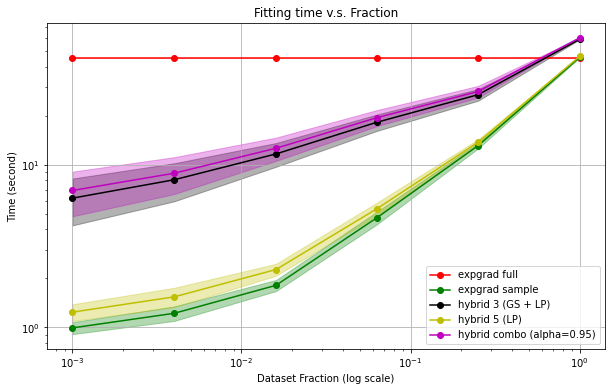

In [ ]:
# Print Time and plot them
# fr = np.log10(fractions)
fr = fractions

import matplotlib
import matplotlib.pyplot as plt

n = len(time_expgrad_alls_ci)

# plt.fill_between(fr, 
#                  time_unmitigated_ci[:,1], 
#                  time_unmitigated_ci[:,2], 
#                  color='b', alpha=0.3)
# plt.plot(fr, time_unmitigated_ci[:,0], 'bo-', label="unmitigated")

plt.fill_between(fr, 
                 time_expgrad_alls_ci[:,1], 
                 time_expgrad_alls_ci[:,2], 
                 color='r', alpha=0.3)
plt.plot(fr, time_expgrad_alls_ci[:,0], 'ro-', label="expgrad full")

plt.fill_between(fr, 
                 time_expgrad_fracs_ci[:,1], 
                 time_expgrad_fracs_ci[:,2], 
                 color='g', alpha=0.3)
plt.plot(fr, time_expgrad_fracs_ci[:,0], 'go-', label="expgrad sample")

# plt.fill_between(fr, 
#                  time_hybrid1_ci[:,1], 
#                  time_hybrid1_ci[:,2], 
#                  color='k', alpha=0.3)
# plt.plot(fr, time_hybrid1_ci[:,0], 'bo-', label="hybrid 1 (GS only)")

# plt.fill_between(fr, 
#                  time_hybrid2_ci[:,1], 
#                  time_hybrid2_ci[:,2], 
#                  color='c', alpha=0.3)
# plt.plot(fr, time_hybrid2_ci[:,0], 'co-', label="hybrid 2 (GS + pmf_predict)")

plt.fill_between(fr, 
                 time_hybrid3_ci[:,1], 
                 time_hybrid3_ci[:,2], 
                 color='k', alpha=0.3)
plt.plot(fr, time_hybrid3_ci[:,0], 'ko-', label="hybrid 3 (GS + LP)")

# plt.fill_between(fr, 
#                  time_hybrid4_ci[:,1], 
#                  time_hybrid4_ci[:,2], 
#                  color='m', alpha=0.3)
# plt.plot(fr, time_hybrid4_ci[:,0], 'mo-', label="hybrid 4 (GS + LP+)")

plt.fill_between(fr, 
                 time_hybrid5_ci[:,1], 
                 time_hybrid5_ci[:,2], 
                 color='y', alpha=0.3)
plt.plot(fr, time_hybrid5_ci[:,0], 'yo-', label="hybrid 5 (LP)")

plt.fill_between(fr, 
                 time_hybrid_combo_ci[:,1], 
                 time_hybrid_combo_ci[:,2], 
                 color='m', alpha=0.3)
plt.plot(fr, time_hybrid_combo_ci[:,0], 'mo-', label=f"hybrid combo (alpha={alpha})")

plt.xlabel('Dataset Fraction (log scale)')
plt.ylabel('Time (second)')
plt.title('Fitting time v.s. Fraction')
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)
plt.show()

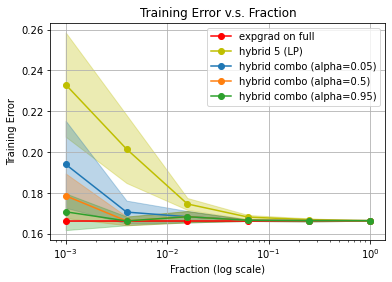

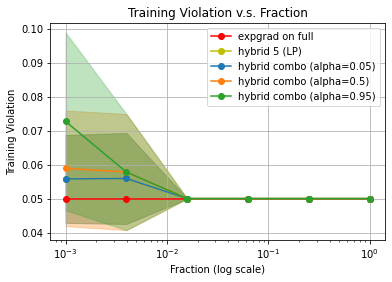

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
cols = list(mcolors.TABLEAU_COLORS.keys())

errors = {
#     "unmitigated": ("b", "unmitigated", train_error_unmitigated_ci, None),
#     "expgrad_fracs": ("g", "expgrad on partial", train_error_expgrad_fracs_ci, None),
    "expgrad_alls": ("r", "expgrad on full", train_error_expgrad_alls_ci, None),
    "no_grid_rewts": ("y", "hybrid 5 (LP)", train_error_no_grid_rewts_ci, None),
#     "rewts_pmf": ("k", "hybrid 3 (GS + LP)", train_error_rewts_pmf_ci, None),
#     "grid_pmf_fracs": ("c", "hybrid 2 (GS + pmf_predict)", train_error_grid_pmf_fracs_ci, None),
#     "rewts_partial": ("m", "hybrid 4 (GS + LP+)", train_error_rewts_partial_ci, None),
#     "hybrid_1": ("k", "hybrid 1 (GS only)", train_error_hybrids_ci, None),
}

violations = {
#     "unmitigated": ("b", "unmitigated", train_vio_unmitigated_ci, None),
#     "expgrad_fracs": ("g", "expgrad on partial", train_vio_expgrad_fracs_ci, None),
    "expgrad_alls": ("r", "expgrad on full", train_vio_expgrad_alls_ci, None),
    "no_grid_rewts": ("y", "hybrid 5 (LP)", train_vio_no_grid_rewts_ci, None),
#     "rewts_pmf": ("k", "hybrid 3 (GS + LP)", train_vio_rewts_pmf_ci, None),
#     "grid_pmf_fracs": ("c", "hybrid 2 (GS + pmf_predict)", train_vio_grid_pmf_fracs_ci, None),
#     "rewts_partial": ("m", "hybrid 4 (GS + LP+)", train_vio_rewts_partial_ci, None),
#     "hybrid_1": ("k", "hybrid 1 (GS only)", train_vio_hybrids_ci, None),
}

# Add alpha combos
for i, alpha in enumerate(alphas):
    errors[f"combo[{alpha}]"] =     (cols[i], f"hybrid combo (alpha={alpha})", train_err_combo_ci[alpha], None)
    violations[f"combo[{alpha}]"] = (cols[i], f"hybrid combo (alpha={alpha})", train_vio_combo_ci[alpha], None)

# Plot errors
for k, (c1, label, means, stds) in errors.items():
    plt.fill_between(fr, means[:,1], means[:,2], color=c1, alpha=0.3)
    plt.plot(fr, means[:,0], c1, marker="o", label=label)
    
plt.xlabel('Fraction (log scale)')
plt.ylabel('Training Error')
plt.title('Training Error v.s. Fraction')
plt.xscale("log")
# plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

# Plot violations
for k, (c1, label, means, stds) in violations.items():
    plt.fill_between(fr, means[:,1], means[:,2], color=c1, alpha=0.3)
    plt.plot(fr, means[:,0], c1, marker="o", label=label)
    
plt.xlabel('Fraction (log scale)')
plt.ylabel('Training Violation')
plt.title('Training Violation v.s. Fraction')
plt.xscale("log")
# plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

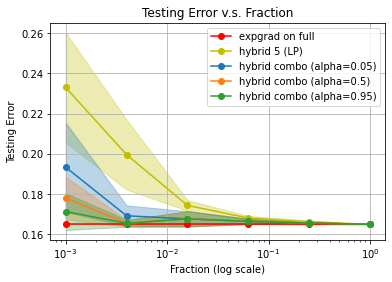

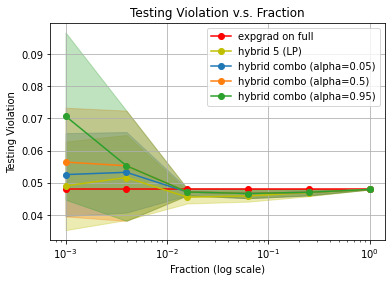

In [ ]:
errors = {
#     "unmitigated": ("b", "unmitigated", test_error_unmitigated_ci, None),
#     "expgrad_fracs": ("g", "expgrad on partial", test_error_expgrad_fracs_ci, None),
    "expgrad_alls": ("r", "expgrad on full", test_error_expgrad_alls_ci, None),
    "no_grid_rewts": ("y", "hybrid 5 (LP)", test_error_no_grid_rewts_ci, None),
#     "rewts_pmf": ("k", "hybrid 3", test_error_rewts_pmf_ci, None),
#     "grid_pmf_fracs": ("c", "hybrid 2", test_error_grid_pmf_fracs_ci, None),
#     "rewts_partial": ("m", "hybrid 4", test_error_rewts_partial_ci, None),
#     "hybrid_1": ("k", "hybrid 1", test_error_hybrids_ci, None),
}

violations = {
#     "unmitigated": ("b", "unmitigated", test_vio_unmitigated_ci, None),
#     "expgrad_fracs": ("g", "expgrad on partial", test_vio_expgrad_fracs_ci, None),
    "expgrad_alls": ("r", "expgrad on full", test_vio_expgrad_alls_ci, None),
    "no_grid_rewts": ("y", "hybrid 5 (LP)", test_vio_no_grid_rewts_ci, None),
#     "rewts_pmf": ("k", "hybrid 3", test_vio_rewts_pmf_ci, None),
#     "grid_pmf_fracs": ("c", "hybrid 2", test_vio_grid_pmf_fracs_ci, None),
#     "rewts_partial": ("m", "hybrid 4", test_vio_rewts_partial_ci, None),
#     "hybrid_1": ("k", "hybrid 1", test_vio_hybrids_ci, None),
}

# Add alpha combos
for i, alpha in enumerate(alphas):
    errors[f"combo[{alpha}]"] =     (cols[i], f"hybrid combo (alpha={alpha})", test_err_combo_ci[alpha], None)
    violations[f"combo[{alpha}]"] = (cols[i], f"hybrid combo (alpha={alpha})", test_vio_combo_ci[alpha], None)

# Plot errors
for k, (c1, label, means, stds) in errors.items():
    plt.fill_between(fr, means[:,1], means[:,2], color=c1, alpha=0.3)
    plt.plot(fr, means[:,0], c1, marker="o", label=label)
    
plt.xlabel('Fraction (log scale)')
plt.ylabel('Testing Error')
plt.title('Testing Error v.s. Fraction')
plt.xscale("log")
# plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

# Plot violations
for k, (c1, label, means, stds) in violations.items():
    plt.fill_between(fr, means[:,1], means[:,2], color=c1, alpha=0.3)
    plt.plot(fr, means[:,0], c1, marker="o", label=label)
    
plt.xlabel('Fraction (log scale)')
plt.ylabel('Testing Violation')
plt.title('Testing Violation v.s. Fraction')
plt.xscale("log")
# plt.yscale("log")
plt.grid()
plt.legend()
plt.show()